In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


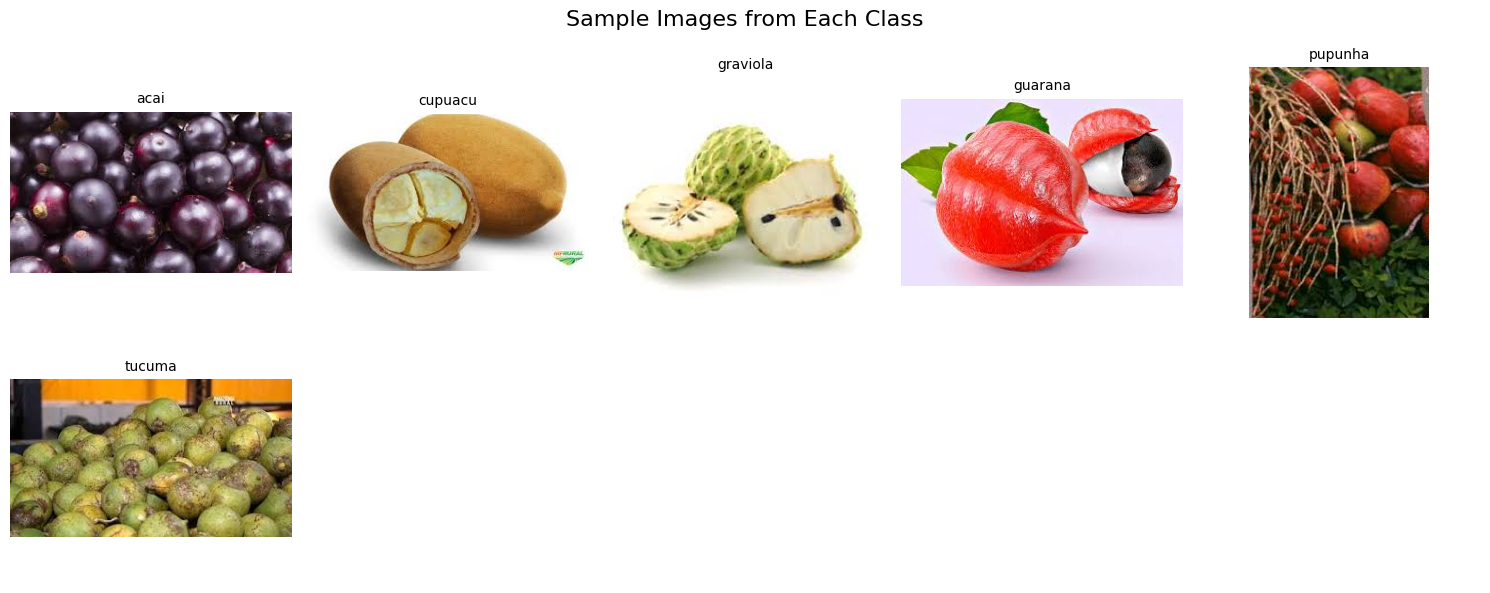

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/AI2/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


What did you Observe?

Each image represents a different class, confirming correct dataset structure.
Images vary in resolution, lighting, and orientation.
Some classes may have fewer images, indicating dataset imbalance.
Preprocessing (resizing, normalization) may be needed for consistency.

In [3]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/AI2/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [4]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'RenjenSherpa.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.1453 - loss: 1.8942
Epoch 1: val_loss improved from inf to 2.10682, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 759ms/step - accuracy: 0.1437 - loss: 1.9090 - val_accuracy: 0.0000e+00 - val_loss: 2.1068
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.1939 - loss: 1.7755
Epoch 2: val_loss improved from 2.10682 to 1.72265, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 792ms/step - accuracy: 0.2010 - loss: 1.7704 - val_accuracy: 0.2222 - val_loss: 1.7227
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.3675 - loss: 1.6725
Epoch 3: val_loss did not improve from 1.72265
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 434ms/step - accuracy: 0.3832 - loss: 1.6665 - val_accuracy: 0.0000e+00 - val_loss: 2.4200
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.1985 - loss: 1.9884
Epoch 4: val_loss improved from 1.72265 to 1.46213, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 472ms/step - accuracy: 0.2079 - loss: 1.9644 - val_accuracy: 0.8333 - val_loss: 1.4621
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7205 - loss: 1.4525
Epoch 5: val_loss did not improve from 1.46213
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.7174 - loss: 1.4516 - val_accuracy: 0.3889 - val_loss: 1.7296
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4369 - loss: 1.3768
Epoch 6: val_loss improved from 1.46213 to 1.04930, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - accuracy: 0.4562 - loss: 1.3614 - val_accuracy: 0.7222 - val_loss: 1.0493
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 577ms/step - accuracy: 0.6846 - loss: 1.0579
Epoch 7: val_loss did not improve from 1.04930
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 727ms/step - accuracy: 0.6871 - loss: 1.0567 - val_accuracy: 0.2778 - val_loss: 1.6613
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.6794 - loss: 0.9158
Epoch 8: val_loss improved from 1.04930 to 0.82198, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 0.6832 - loss: 0.9051 - val_accuracy: 0.8889 - val_loss: 0.8220
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8050 - loss: 0.5941
Epoch 9: val_loss improved from 0.82198 to 0.58568, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 480ms/step - accuracy: 0.8051 - loss: 0.5931 - val_accuracy: 0.7778 - val_loss: 0.5857
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9294 - loss: 0.3813
Epoch 10: val_loss did not improve from 0.58568
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.9332 - loss: 0.3735 - val_accuracy: 0.3333 - val_loss: 1.1430
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8941 - loss: 0.2720
Epoch 11: val_loss did not improve from 0.58568
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.8997 - loss: 0.2641 - val_accuracy: 0.7222 - val_loss: 0.6835
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 613ms/step - accuracy: 0.8588 - loss: 0.3586
Epoch 12: val_loss improved from 0.58568 to 0.40493, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 863ms/step - accuracy: 0.8663 - loss: 0.3467 - val_accuracy: 0.8333 - val_loss: 0.4049
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 1.0000 - loss: 0.0790
Epoch 13: val_loss improved from 0.40493 to 0.37125, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - accuracy: 1.0000 - loss: 0.0780 - val_accuracy: 0.8333 - val_loss: 0.3712
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0445
Epoch 14: val_loss did not improve from 0.37125
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 1.0000 - loss: 0.0447 - val_accuracy: 0.8333 - val_loss: 0.3774
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 1.0000 - loss: 0.0299
Epoch 15: val_loss improved from 0.37125 to 0.35282, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 551ms/step - accuracy: 1.0000 - loss: 0.0295 - val_accuracy: 0.8333 - val_loss: 0.3528
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 1.0000 - loss: 0.0193
Epoch 16: val_loss improved from 0.35282 to 0.34888, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 602ms/step - accuracy: 1.0000 - loss: 0.0189 - val_accuracy: 0.8333 - val_loss: 0.3489
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 537ms/step - accuracy: 1.0000 - loss: 0.0135
Epoch 17: val_loss did not improve from 0.34888
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 717ms/step - accuracy: 1.0000 - loss: 0.0131 - val_accuracy: 0.8333 - val_loss: 0.3548
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 1.0000 - loss: 0.0074
Epoch 18: val_loss did not improve from 0.34888
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 1.0000 - loss: 0.0075 - val_accuracy: 0.8333 - val_loss: 0.3700
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 1.0000 - loss: 0.0055
Epoch 19: val_loss did not improve from 0.34888
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.8333 - val_loss: 0.3852
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 1.0000 - loss: 0.0042
Epoch 20: val_loss did not improve from 0.34888
3/3 

In [8]:
test_dir = '/content/drive/MyDrive/AI2/FruitinAmazon/test'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.7333 - loss: 162.8487
Test Loss: 162.8486785888672
Test Accuracy: 0.7333333492279053


In [9]:
model.save('RijanManandhar_Model.h5')
print("Model saved successfully!")

Model saved successfully!


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.60      0.60      0.60         5
           2       0.56      1.00      0.71         5
           3       0.80      0.80      0.80         5
           4       1.00      0.80      0.89         5
           5       1.00      0.40      0.57         5

    accuracy                           0.73        30
   macro avg       0.79      0.73      0.73        30
weighted avg       0.79      0.73      0.73        30

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 1.0000 - loss: 0.0147
Epoch 1: val_loss did not improve from 0.34888
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8333 - val_loss: 0.3689
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 1.0000 - loss: 0.0106
Epoch 2: val_loss did not improve from 0.34888
3/3 ━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 482ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.8333 - val_loss: 0.3388
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 1.0000 - loss: 0.0061
Epoch 5: val_loss improved from 0.33877 to 0.32782, saving model to RenjenSherpa.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 555ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.8333 - val_loss: 0.3278
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 6: val_loss did not improve from 0.32782
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.8333 - val_loss: 0.3311
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 1.0000 - loss: 0.0043
Epoch 7: val_loss did not improve from 0.32782
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.8333 - val_loss: 0.3658
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 1.0000 - loss: 0.0031
Epoch 8: val_loss did not improve from 0.32782
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.8333 - val_loss: 0.4294
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0034
Epoch 9: val_loss did not improve from 0.32782
3/3 ━━━━━━━━

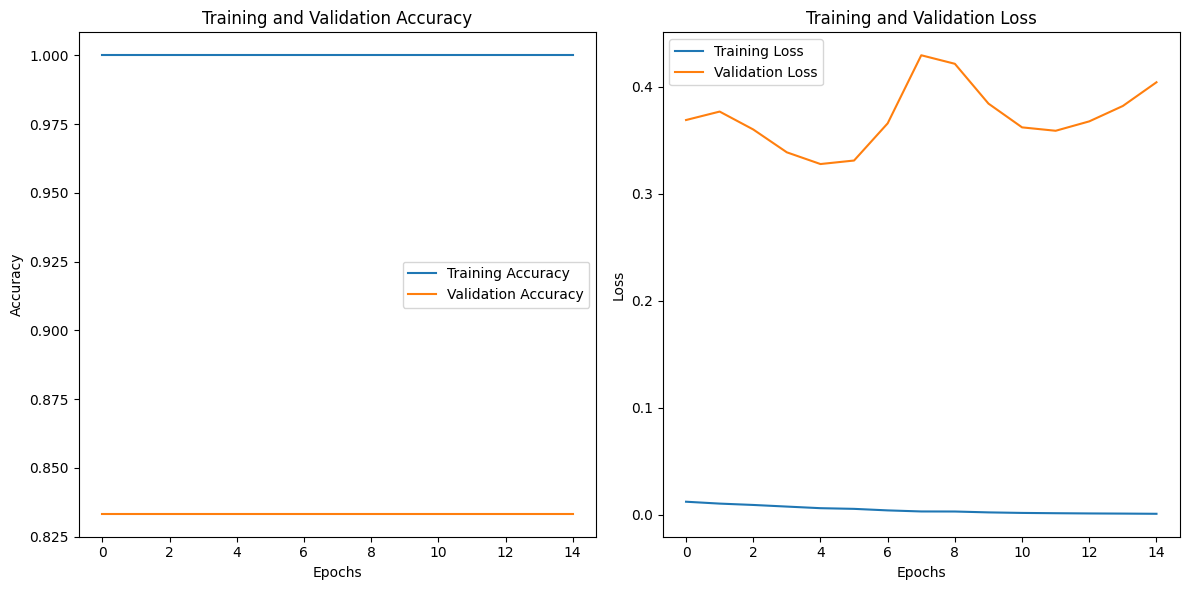

Model saved as 'Rijan_mananadhar_model.h5'


In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('RijanManandhar_Model.h5')
print("Model saved as 'Rijan_mananadhar_model.h5'")